# SIZRS_plots

Load & plot AXCTD data from the SIZRS experiment

http://psc.apl.uw.edu/research/projects/sizrs/

data were

k.drushka // Jan 2022/data1/sassie/prior/SIZRS/AXCTD/SIZRS_2019_AXCTDs/

In [1]:
import sys
import os
import numpy as np
import glob
from datetime import datetime, time, date, timedelta
import pandas as pd
import xarray as xr


import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mticker


In [2]:
sizrsdir = '/data1/sassie/prior/SIZRS/AXCTD/'
seaicedir = '/data1/sassie/satellite/seaice/sic_daily_v3/regridded/'
savedir = '/data1/sassie/process/'
figdir = '/data2/Dropbox/projects/sassie_kd/figures/prior/'

In [3]:
# specify year(s) and month(s) to process
# years from 2012 to 2019 and months 6-10 are typically available
years = range(2012,2020)


# variables to store
vbls = ['Temp', 'Salinity', 'Sigma']

In [4]:
# grid each variable to standard depths
zgrid = np.arange(0,1000,0.1)
zgrid = np.arange(0,50,0.1)



# loop through years
for year in years:
    # initialize output array
    xctd_thisyear = xr.Dataset(coords={'z':zgrid, 't':time})
    thisdir = f'{sizrsdir}SIZRS_{year}_AXCTDs/'
    monthdirs = sorted(glob.glob(thisdir + '*AXCTDs_*'))
    for monthdir in monthdirs:
        file_list = sorted(glob.glob(monthdir +  '*/AXCTD*.txt'))
        cnt = 0 # count
        for filename in file_list:
            cnt+=1
            # load 
            #print(filename)
            f = open(filename,'r')    
            header = f.readlines()[0:13] 
            f.close()

            # look for header line with lat/lon/date info
            for r in range(np.size(header)):
                i = header[r].find("North")
                if i>0:
                    # TO DO:  make more generic with regexp or similar
                    hsplit = header[r].split(" ")
                    if hsplit[1] == 'degrees': # some files are formatted like this
                        lat = float(hsplit[0])
                        lon = -1*(float(hsplit[5]))
                        time = np.datetime64(datetime.strptime(hsplit[-2],'%Y-%m-%d/%H%M'))
                    else: # some like this
                        lat = float(hsplit[0]) + float(hsplit[2])/60
                        lon = -1*(float(hsplit[6]) + float(hsplit[8])/60)
                        time = np.datetime64(datetime.strptime(hsplit[-2],'%Y-%m-%d/%H%M'))

            # load data into a pandas dataframe:
            df = pd.read_csv(filename, sep='\s+', skiprows=15, names=["Depth", "Pres", "Temp", "Cond", "Salinity", "Sigma"])

            # if this is the first file in the month, initialize the xr dataset and add time
            
            if cnt==1:
                xctd_thismonth = xr.Dataset(coords={'z':zgrid, 't':time})
                
            # interpolate each variable to zgrid and store in the xarray dataset:
            # add data to the new xarray dataset this_xctd
            this_xctd = xr.Dataset(coords={'z':zgrid, 't':time, 'x':lon, 'y':lat})
            for vbl in vbls:
                this_xctd[vbl] = xr.DataArray(data=np.interp(zgrid, df['Depth'], df[vbl]), dims=['z'])

    
            # concatenate files
            xctd_thisyear = xr.concat([xctd_thisyear, this_xctd], dim='t')
            xctd_thismonth = xr.concat([xctd_thismonth, this_xctd], dim='t')
            
            
        # at the end of each month, save the month file
        filename_out = f'{savedir}SIZRS_{np.datetime_as_string(time, unit="M")}.nc'
        print(filename_out)
        xctd_thismonth = xctd_thismonth.sortby('t')
        xctd_thismonth.to_netcdf(filename_out)


/data1/sassie/process/SIZRS_2012-08.nc
/data1/sassie/process/SIZRS_2012-07.nc
/data1/sassie/process/SIZRS_2012-06.nc
/data1/sassie/process/SIZRS_2012-05.nc
/data1/sassie/process/SIZRS_2012-10.nc
/data1/sassie/process/SIZRS_2012-09.nc
/data1/sassie/process/SIZRS_2013-08.nc
/data1/sassie/process/SIZRS_2013-07.nc
/data1/sassie/process/SIZRS_2013-06.nc
/data1/sassie/process/SIZRS_2014-08.nc
/data1/sassie/process/SIZRS_2014-07.nc
/data1/sassie/process/SIZRS_2014-06.nc
/data1/sassie/process/SIZRS_2014-10.nc
/data1/sassie/process/SIZRS_2014-09.nc
/data1/sassie/process/SIZRS_2015-08.nc
/data1/sassie/process/SIZRS_2015-07.nc
/data1/sassie/process/SIZRS_2015-07.nc
/data1/sassie/process/SIZRS_2015-09.nc
/data1/sassie/process/SIZRS_2016-08.nc
/data1/sassie/process/SIZRS_2016-07.nc
/data1/sassie/process/SIZRS_2016-06.nc
/data1/sassie/process/SIZRS_2016-10.nc
/data1/sassie/process/SIZRS_2016-09.nc
/data1/sassie/process/SIZRS_2017-07.nc
/data1/sassie/process/SIZRS_2017-06.nc
/data1/sassie/process/SIZ

## Load .nc files created above and plot

2013-06-19
2013-07-16
2014-09-24
2015-07-23
2019-08-14
2019-10-10
2015-09-09
2013-08-13
2016-07-13
2014-06-17
2012-07-25
2015-08-11
2012-06-27
2017-10-21
2017-08-17
2012-05-30
2017-06-15
2018-10-09
2016-09-14
2012-09-18
2017-07-11
2018-07-30
2016-06-15
2019-09-12
2018-09-18
2018-05-31
2012-10-16
2014-07-23
2016-10-06
2016-08-18
Exception thrown. Skipping
2019-06-12
2014-08-13
2012-08-21
2014-10-14
2019-07-10


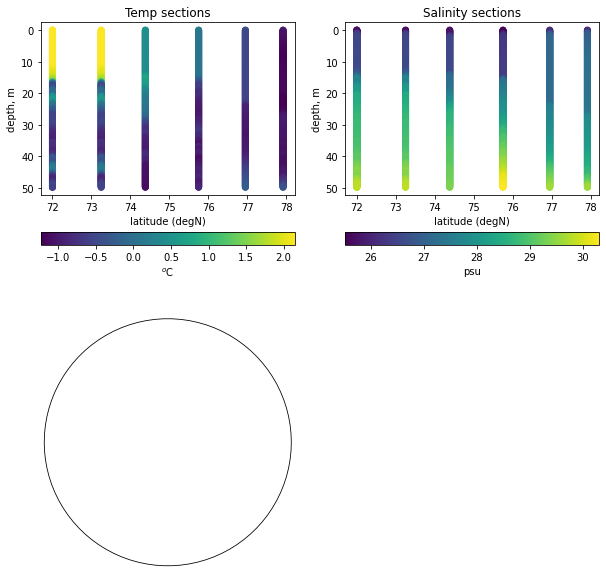

In [5]:
# all SIZRS .nc files we've made
allfiles = glob.glob(savedir + 'SIZRS*')
vbl_units = ['$^o$C', 'psu'] # corresponding to temp, sal
for fn in allfiles:
    # open dataset with xarray
    ds = xr.open_mfdataset(fn)
    thisdate = np.datetime_as_string(ds.t.isel(t=0), unit="D")
    print(thisdate)
    try:
        # set up figure
        fig = plt.figure(figsize=(10,10))  

        # top panels: scatterplot depth-lat sections
        [ypl, zpl] = np.meshgrid(ds.y.data, ds.z.data) # lat/depth
        for vi in [0,1]:
            ax = fig.add_subplot(2,2,vi+1)
            sc = ax.scatter(ypl, zpl, c=np.transpose(ds[vbls[vi]].data))
            ax.invert_yaxis()
            ax.set_title(f'{vbls[vi]} sections')
            ax.set_xlabel('latitude (degN)')
            ax.set_ylabel('depth, m')
            plt.colorbar(sc, ax=ax, orientation="horizontal").set_label(vbl_units[vi])

        # bottom panels: map of SST/SSS, with SIC
        # first load SIC (see satellite/convert_sea_ice_coords.ipynb)
        da = np.datetime_as_string(ds.t.isel(t=0), unit="D")
        sicfile = sorted(glob.glob(seaicedir + '**' + da[0:4] + da[5:7] + da[8:10] + '**nc'))
        if not(sicfile):
            PLOT_SIC = 0
        else:
            sicds = xr.open_mfdataset(sicfile)
            # 0-360 => -180-180
            sicds.coords['lon'] = (sicds.coords['lon'] + 180) % 360 - 180
            sicds = sicds.sortby(sicds.lon)
            sic_level = 0.15
            xrange = slice(-180, -130)
            yrange = slice(50, 80)
            sicdata = sicds.seaice_conc_cdr.sel(lon=xrange, lat=yrange).isel(time=0).data
            PLOT_SIC = 1


        # map plot SSS/SST
        for vi in [0,1]:
            xpl = ds.x.data
            ypl = ds.y.data
            ax1 = fig.add_subplot(2,2,3+vi, projection=ccrs.NorthPolarStereo(central_longitude=-150))
            data = ds[vbls[vi]].isel(z=0).data
            pc = ax1.scatter(xpl, ypl, c=data, transform=ccrs.PlateCarree(), zorder=10)
            ax1.coastlines(color='none')  # coastline
            ax1.set_extent([-170, -130,68, 80], crs=ccrs.PlateCarree())
            gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3)
            plt.colorbar(pc, ax=ax1, orientation="horizontal", pad=0.1).set_label(vbl_units[vi])
            ax1.set_title('Surface ' + vbls[vi], pad=0.1)

            # land color
            ax1.add_feature(cartopy.feature.LAND , facecolor=(.7,.7,.7))
            # ticks
            gl.ylocator = mticker.FixedLocator([68, 70, 72, 74, 76, 78])
            gl.xlocator = mticker.FixedLocator([-170, -160, -150, -140, -130])
            gl.top_labels = False
            gl.bottom_labels = True


            # add SIC
            if PLOT_SIC:
                c = ax1.contour(sicds.lon.sel(lon=xrange).data, sicds.sel(lat=yrange).lat.data,sicdata,
                                    levels=[sic_level],
                                    colors='k',
                                    transform=ccrs.PlateCarree())

                pc = ax1.pcolormesh(sicds.lon.sel(lon=xrange).data, sicds.sel(lat=yrange).lat.data,sicdata,
                       transform=ccrs.PlateCarree(),
                       vmin = 0,
                       vmax = 1,
                       cmap = 'Greys_r')
        # save this figure:
        plt.suptitle(f'SIZRS {thisdate}')
        plt.savefig(f'{figdir}SIZRS_{thisdate}.png', dpi=400, transparent=False, facecolor='white')
        plt.close()
    except:
        print("Exception thrown. Skipping")

In [6]:
# all files
dsa = xr.open_mfdataset(allfiles)

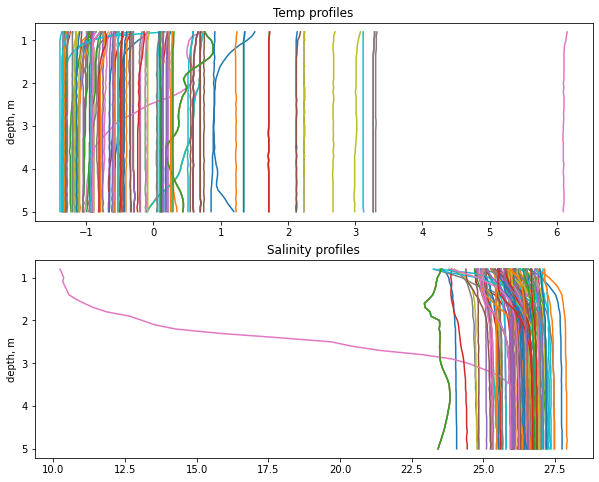

In [12]:
# profiles
dsapl = dsa.sel(z=slice(0,10))
dsapl = dsa.sel(z=slice(.75,5)).where(dsapl.t.dt.month>=8)

# set up figure
fig = plt.figure(figsize=(10,8))  

# 
for vi in [0,1]:
    axx = fig.add_subplot(2,1,vi+1)
    plt.plot(np.transpose(dsapl[vbls[vi]].data), dsapl.z.data)
    axx.invert_yaxis()
    axx.set_title(f'{vbls[vi]} profiles')
    axx.set_ylabel('depth, m')
   

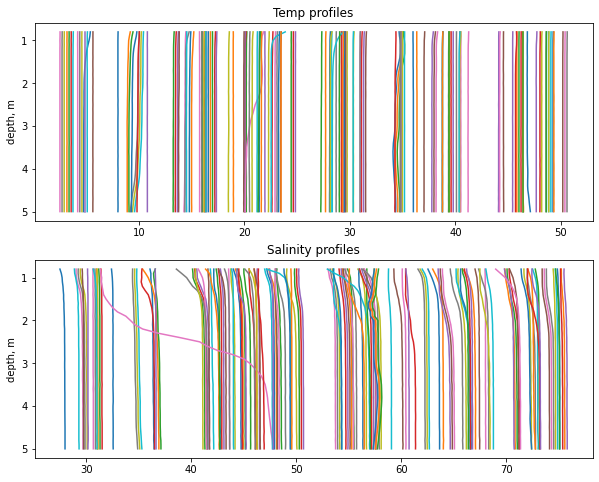

In [29]:
# profiles offset
# set up figure
fig = plt.figure(figsize=(10,8))  

# 
for vi in [0,1]:
    axx = fig.add_subplot(2,1,vi+1)
    for j in np.arange(dsapl.t.shape[0]):
        plt.plot(np.transpose(dsapl[vbls[vi]].isel(t=j).data)+0.2*j, dsapl.z.data)
    axx.invert_yaxis()
    axx.set_title(f'{vbls[vi]} profiles')
    axx.set_ylabel('depth, m')

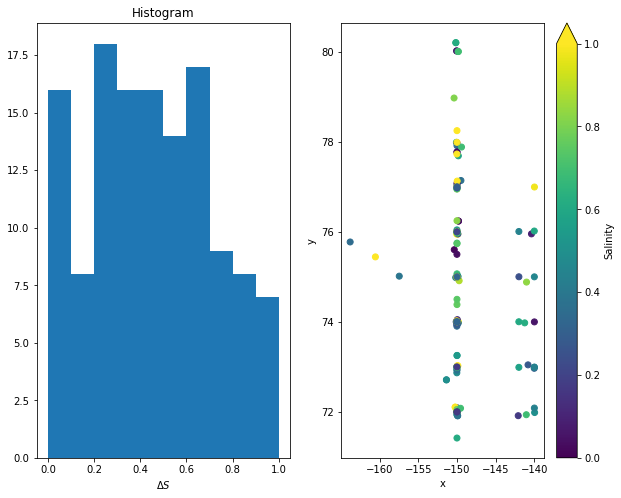

In [34]:
# delta s
dsdels = dsa.sel(z=[1, 5]).diff(dim='z').where(dsapl.t.dt.month>=8).where(dsapl.t.dt.month<=10)
# dsdels = dsa.sel(z=[1, 5]).diff(dim='z').where(dsapl.t.dt.month>=8).where(dsapl.t.dt.month<=10).isel(t=0)

# set up figure
fig = plt.figure(figsize=(10,8))  
ax = fig.add_subplot(1,2,1)
xr.plot.hist(dsdels['Salinity'], bins=10, range=(0, 1))
ax.set_xlabel('$\Delta S$')


ax = fig.add_subplot(1,2,2)
xr.plot.scatter(dsdels, 'x', 'y', hue='Salinity', vmin=0, vmax=1)
plt.show()
#     plt.plot(np.transpose(dsapl[vbls[vi]].data), dsapl.z.data)
#     axx.invert_yaxis()
#     axx.set_title(f'{vbls[vi]} profiles')
#     axx.set_ylabel('depth, m')
   

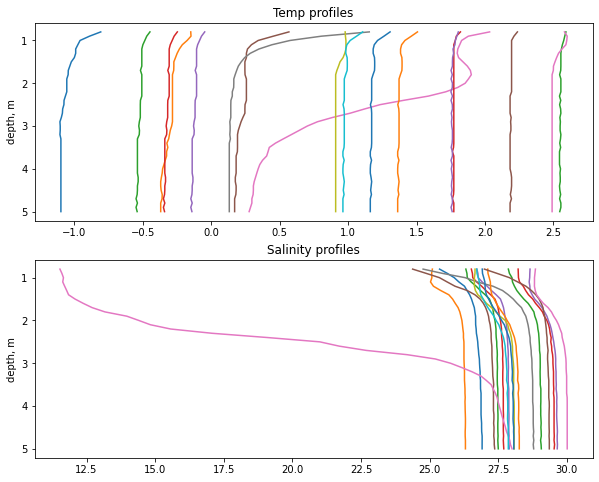

In [68]:
fig = plt.figure(figsize=(10,8)) 
(js,dum) = np.where(dsdels.Salinity>1)
for vi in [0,1]:
    axx = fig.add_subplot(2,1,vi+1)
    c=0
    for j in js:
        c+=1
        plt.plot(np.transpose(dsapl[vbls[vi]].isel(t=j).data)+0.2*c, dsapl.z.data)
    axx.invert_yaxis()
    axx.set_title(f'{vbls[vi]} profiles')
    axx.set_ylabel('depth, m')
# bigds = dsdels.where(dsdels.Salinity>0.5)
# bigds['Salinity'].values

In [64]:
(j,dum) = np.where(dsdels.Salinity>0.5)
j

array([ 16,  17,  18,  51,  52,  53,  72,  73,  74,  77,  78,  80,  81,
        94, 102, 103, 106, 109, 110, 111, 113, 117, 118, 119, 136, 137,
       138, 139, 140, 141, 143, 144, 145, 146, 147, 149, 151, 153, 154,
       155, 156, 157, 158, 173, 175, 180, 181, 194, 195, 196, 197, 198,
       199, 200, 201, 207, 208, 209, 221, 222, 223, 224, 225, 226, 227,
       228, 230, 233, 234, 235, 236, 237])

In [95]:
# load all sic
sicall = xr.open_mfdataset(seaicedir + '**nc')

In [113]:
# 0-360 => -180-180
sicall.coords['lon'] = (sicall.coords['lon'] + 180) % 360 - 180
sicall = sicall.sortby(sicall.lon)

In [141]:
# interpolate SIC to the buoy sites
# dsdels['sic'] =  sicall.seaice_conc_cdr.interp(lat=dsdels['y'], lon=dsdels['x'], time=dsdels['t'])
# dsdels['sic'] =  
# dsdels = dsdels.isel(t=1)
sicall.seaice_conc_cdr.interp(lat=dsdels['y'], lon=dsdels['x'], time=dsdels['t'])



InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [139]:
[dsdels['y'].values, dsdels['x'].values, dsdels['t'].values]

[array(75.96666667),
 array(-149.86666667),
 numpy.datetime64('2012-05-30T23:31:00.000000000')]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

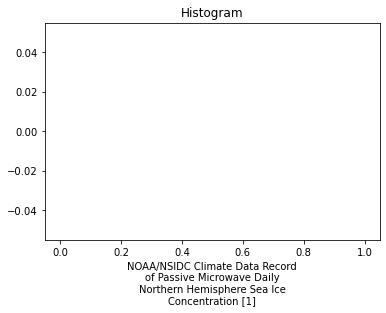

In [104]:
xr.plot.hist(dsdels['sic'])

In [109]:
dsdels['x']

<xarray.DataArray 'x' (t: 245)>
dask.array<concatenate, shape=(245,), dtype=float64, chunksize=(12,), chunktype=numpy.ndarray>
Coordinates:
    y        (t) float64 dask.array<chunksize=(6,), meta=np.ndarray>
    x        (t) float64 dask.array<chunksize=(6,), meta=np.ndarray>
  * t        (t) datetime64[ns] 2012-05-30T23:31:00 ... 2019-10-10T20:16:00
    lat      (t) float64 75.97 75.97 74.96 73.97 72.99 ... 74.0 75.0 76.0 77.0
    lon      (t) float64 -149.9 -149.9 -150.0 -150.1 ... -150.0 -150.0 -150.0
    time     (t) datetime64[ns] 2012-05-30T23:31:00 ... 2019-10-10T20:16:00

In [118]:
np.unique(sicall['lon'].shape)

array([3601])